<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# openEO Platform

## Advanced data processing - Snow monitoring

Author: Claus Michele - Institute for Earth Observation - EURAC Research ([contacts](https://www.eurac.edu/en/people/michele-claus))

In [1]:
import openeo
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt

Before starting, please check to have the latest version of openeo installed. At least version 0.10.0 is recommended.

In [2]:
openeo.client_version()

'0.10.1'

Connect and authenticate with openEO Platform

In [3]:
backend = 'https://openeo.cloud'
conn = openeo.connect(backend).authenticate_oidc()

Authenticated using refresh token.


This is the pre-defined AOI for this example. It is covering the [Orobie Alps](https://en.wikipedia.org/wiki/Bergamasque_Alps), including mountain peaks up to 3038 meters high.

In [4]:
spatial_extent  = {'west': 9.663849, 'east': 10.200806, 'south': 46.009728, 'north': 46.135486}

We will consider a temporal extent which comprises winter and spring:

In [5]:
temporal_extent = ['2020-11-01', '2021-06-30']

### Snow mask generation with Sentinel-2 SCL layer (Scene Classification)

You can find more information about the Sentinel-2 SCL layer here https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

If you want to know more about the Sentinel-2 L2A collection, uncomment and run the next cell.

In [6]:
# conn.describe_collection('SENTINEL2_L2A') 

In [6]:
S2_SCL = conn.load_collection(
    'SENTINEL2_L2A',
    spatial_extent=spatial_extent,
    bands=['SCL'],
    temporal_extent=temporal_extent)

We generate a boolean mask based on the SCL layer. Where SCL has value 11 (snow and ice), our mask will be set to 1.

In [7]:
S2_SCL_snow = (S2_SCL.band("SCL") == 11)

We can use aggregate_temporal_period to get a weekly snow mask.

More information about `aggregate_temporal_period` can be found here:

https://processes.openeo.org/#aggregate_temporal_period

https://open-eo.github.io/openeo-python-client/api.html?highlight=aggregate_temporal_period#openeo.rest.datacube.DataCube.aggregate_temporal_period

In [8]:
S2_SCL_snow_weekly = S2_SCL_snow.aggregate_temporal_period(period='week',reducer='max')

We can now download the result with a sync call.

Please note: this works only for limited areas. For larger processing use a batch job instead.

In [9]:
S2_SCL_snow_weekly.download('S2_SCL_snow_weekly_Orobie_Alps.nc')

Using xArray, we can open and visualize our result:

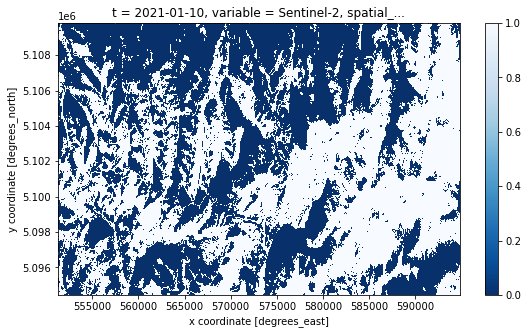

In [2]:
S2_SCL_snow_weekly_ds = xr.open_dataset('S2_SCL_snow_weekly_Orobie_Alps.nc')
S2_crs = S2_SCL_snow_weekly_ds.crs.attrs['crs_wkt']
S2_SCL_snow_weekly_ds = S2_SCL_snow_weekly_ds.drop('crs').to_array().rio.write_crs(S2_crs)[0]
S2_SCL_snow_week = S2_SCL_snow_weekly_ds.loc[dict(t=S2_SCL_snow_weekly_ds.t[11])]
S2_SCL_snow_week['variable'] = 'Sentinel-2'
S2_SCL_snow_week.plot.imshow(figsize=(9,5),cmap='Blues_r')

### Optical Sentinel-2 RGB composite of January for visual reference

In [12]:
S2_BGR = conn.load_collection(
    'SENTINEL2_L2A',
    spatial_extent=spatial_extent,
    bands=['B02','B03','B04'],
    temporal_extent=['2021-01-01', '2021-01-31'])

S2_BGR = S2_BGR.reduce_dimension(dimension='t',reducer='min')

S2_BGR.download('S2_BGR_Orobie_Alps.nc')

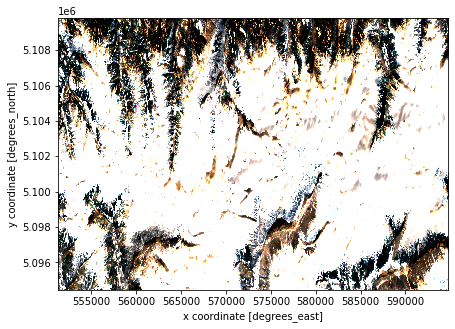

In [3]:
S2_BGR = xr.open_dataset('S2_BGR_Orobie_Alps.nc')
S2_BGR = S2_BGR.rio.write_crs(S2_BGR.crs.attrs['crs_wkt'])
S2_BGR = (S2_BGR.drop('crs').to_array() / 2000).clip(0,1)
S2_BGR.plot.imshow(figsize=(7,5))

### Snow mask generation with MODIS NDSI

Sentinel-2 (A and B) have together a revisit time of 5 days.

This means that data for our area of interest is not updated daily. Therefore, if we would need to get a daily snow cover map, we should use a different data source.

MODIS is designed to provide atleast daily observations, but it has a coarser resolution (~500m) compared to Sentinel-2 (10:60m).

If you want to know more about the MODIS collection, uncomment and run the next cell.

In [14]:
#conn.describe_collection('MODIS') 

In [15]:
MODIS_green_swir  = conn.load_collection(
    'MODIS',
    spatial_extent=spatial_extent,
    bands=['B04','B06'],
    temporal_extent=temporal_extent)

We can compute the NDSI (Normalized Difference Snow Index) using the green (B04) and swir (B06) bands of MODIS.

Additional information about MODIS and the NDSI usage for snow detection can be found here: https://modis-snow-ice.gsfc.nasa.gov/uploads/C6_MODIS_Snow_User_Guide.pdf

In [16]:
MODIS_B04 = MODIS_green_swir.band('B04')
MODIS_B06 = MODIS_green_swir.band('B06')
MODIS_NDSI = (MODIS_B04 - MODIS_B06) / (MODIS_B04 + MODIS_B06)

MODIS acquires data every day, but we would like to compare the result with Sentinel-2. We can again aggregate with a weekly period to align and compare the results.

We compute the maximum value of the NDSI over a week:

In [17]:
MODIS_NDSI_weekly = MODIS_NDSI.aggregate_temporal_period(period='week',reducer='max')

and we consider as covered by snow all the pixels with an NDSI value greater than 0.4:

In [18]:
MODIS_snow_weekly = MODIS_NDSI_weekly > 0.4

In [19]:
MODIS_snow_weekly.download('MODIS_snow_Orobie_Alps.nc')

Now our snow mask is ready. However, if we want to compare it with the Sentinel-2 one, we would need to apply one last step.

MODIS has a different resolution and projection compared to Sentinel-2 and therefore we need to resample MODIS to align with Sentinel-2:

In [5]:
MODIS_snow_weekly = xr.open_dataset('MODIS_snow_Orobie_Alps.nc')
MODIS_crs = MODIS_snow_weekly.crs.attrs['crs_wkt']
MODIS_snow_weekly = MODIS_snow_weekly.drop('crs').to_array().rio.write_crs(4326)[0]

We can finally compare the snow masks using the RGB image as a background:

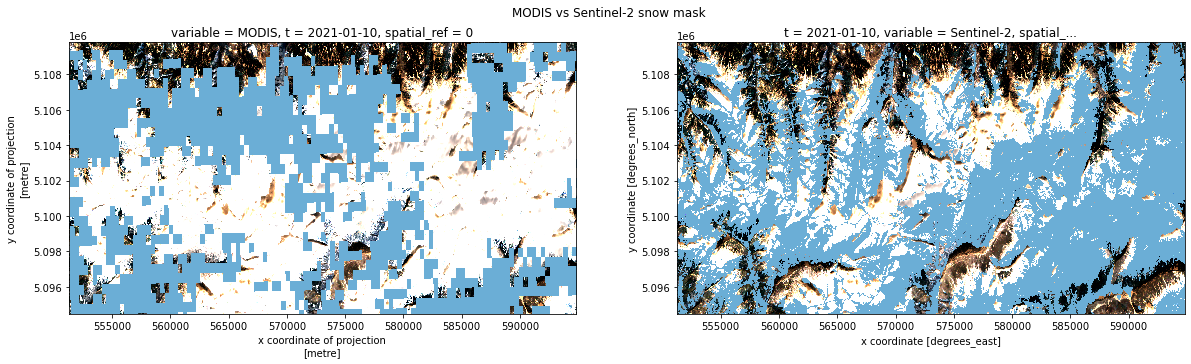

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
MODIS_snow_weekly_UTM = MODIS_snow_weekly[10].rio.reproject_match(S2_SCL_snow_week)
MODIS_snow_weekly_UTM['variable'] = 'MODIS'
S2_SCL_snow_week['variable'] = 'Sentinel-2'
fig.suptitle('MODIS vs Sentinel-2 snow mask')

S2_BGR.plot.imshow(ax=ax[0])
MODIS_snow_weekly_UTM.where(MODIS_snow_weekly_UTM==1).plot.imshow(ax=ax[0],cmap='Blues_r',add_colorbar=False)

S2_BGR.plot.imshow(ax=ax[1])
S2_SCL_snow_week.where(S2_SCL_snow_week==1).plot.imshow(ax=ax[1],cmap='Blues_r',add_colorbar=False)

Note: the snow mask obtained with MODIS does not consider clouds whereas the SCL layer of Sentinel-2 has been processed by a dedicated algorithm.

For more information on how to create a refined snow mask based on MODIS, please refer to the following publications:

[1] _Notarnicola, C., Duguay, M., Moelg, N., Schellenberger, T., Tetzlaff, A., Monsorno, R., Costa, A., Steurer, C. and Zebisch, M., 2013. Snow cover maps from MODIS images at 250 m resolution, Part 1: Algorithm description. Remote Sensing, 5(1), pp.110-126._

[2] _Matiu, M., Jacob, A. and Notarnicola, C., 2019. Daily MODIS snow cover maps for the European Alps from 2002 onwards at 250 m horizontal resolution along with a nearly cloud-free version. Data, 5(1), p.1._

The alignment of MODIS and Sentinel-2 can also be performed also in openEO using `resample_cube_spatial`.

https://processes.openeo.org/#resample_cube_spatial

`MODIS_snow_weekly_UTM = MODIS_snow_weekly.resample_cube_spatial(S2_SCL_snow_weekly)`

### Wetsnow detection using Sentinel-1

Please refer to https://github.com/Open-EO/openeo-usecases/tree/master/eurac_wetsnow_usecase for more information about the original use case.

The Sentinel-1 collection we will use is not global, please have a look here to check if the area you are interested in is covered:

https://editor.openeo.cloud/?preview-collection=S1_GRD_SIGMA0_ASCENDING

https://editor.openeo.cloud/?preview-collection=S1_GRD_SIGMA0_DESCENDING

In [13]:
s1_vvvh = conn.load_collection(
    'S1_GRD_SIGMA0_DESCENDING',
    spatial_extent=spatial_extent, 
    bands=["VV", "VH"],
    temporal_extent=temporal_extent,
).apply(lambda x: 10 * x.log(base=10))

s1_angle = conn.load_collection(
    'S1_GRD_SIGMA0_DESCENDING',
    spatial_extent=spatial_extent, 
    bands=["angle"],
    temporal_extent=["2020-11-01", "2020-11-10"],
)

In the first step every timestep of the Sentinel-1 backscatter data is normalized with the mean of the time series for the two polarizations VV and VH.

In [14]:
rat_vvvh = s1_vvvh.merge_cubes(s1_vvvh.mean_time(), overlap_resolver="subtract")

In the second step the Sentinel-1 local incident angle is classified into a weight layer.

In [15]:
s1_lia_angle = s1_angle.min_time().band("angle") / 1000

theta_1 = 20
theta_2 = 45
k = 0.5

weight = (
    (0.5 * ((theta_2 - s1_lia_angle) * 0.04 + 1))
    .mask(s1_lia_angle < theta_1, replacement=1)
    .mask(s1_lia_angle < theta_2, replacement=k)
)

The time series of the normalized backscatter images and the weight layer are combined in a thrid step to retrieve a wet snow map solely based on Sentinel-1 data.

In [16]:
rc_cube = rat_vvvh.merge_cubes(weight)

from openeo.metadata import Band
rc_cube.metadata = rc_cube.metadata.append_band(Band("angle"))

rc_w = rc_cube.band("angle")
rc = rc_w * rc_cube.band("VH") + (1-rc_w) * rc_cube.band("VV")

rc_weekly = rc.aggregate_temporal_period(period='week',reducer='mean')

wetsnow = rc_weekly.mask(rc_weekly <= -2,replacement = 10).mask(rc_weekly > -2,replacement = 20)

Now the Sentinel-1 based weekly wetsnow map is ready. The final step will consist in using the Sentinel-2 based snow mask to create a final product:

In [17]:
wetsnow_masked = wetsnow.merge_cubes(S2_SCL_snow_weekly,overlap_resolver='multiply')

In [27]:
wetsnow_masked.download('wetsnow_masked.nc')

If the sync call returns an error, please try to use a batch job instead.

For complex and/or large scale processing (at country/continental level), you will probably need to allocate explicitly more resources for it:

In [32]:
# The following job options allow you to increase the computational power dedicated to your job.
# Be aware that the more resources you use, the more openEO Platform credits it will require
job_options = {
    "driver-memory": "2G",
    "driver-memoryOverhead": "2G",
    "driver-cores": "1",
    "executor-memory": "3g",
    "executor-memoryOverhead": "1g",
    "executor-cores": "2",
    "max-executors": "50"
}
job = wetsnow_masked.create_job(title="Wetsnow_2020_2021_Orobie_Alps",job_options=job_options)
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    job.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  vito-75d284ab-0068-45d3-965f-bdc53143b367


In [40]:
conn.job('vito-75d284ab-0068-45d3-965f-bdc53143b367')

<RESTJob job_id='vito-75d284ab-0068-45d3-965f-bdc53143b367'>

Read the output:

In [7]:
wetsnow_output = xr.open_dataset('wetsnow_masked.nc')
wetsnow_output = wetsnow_output.drop('crs').to_array()[0]
wetsnow_output = wetsnow_output.where(wetsnow_output>0)

Visualize the result:

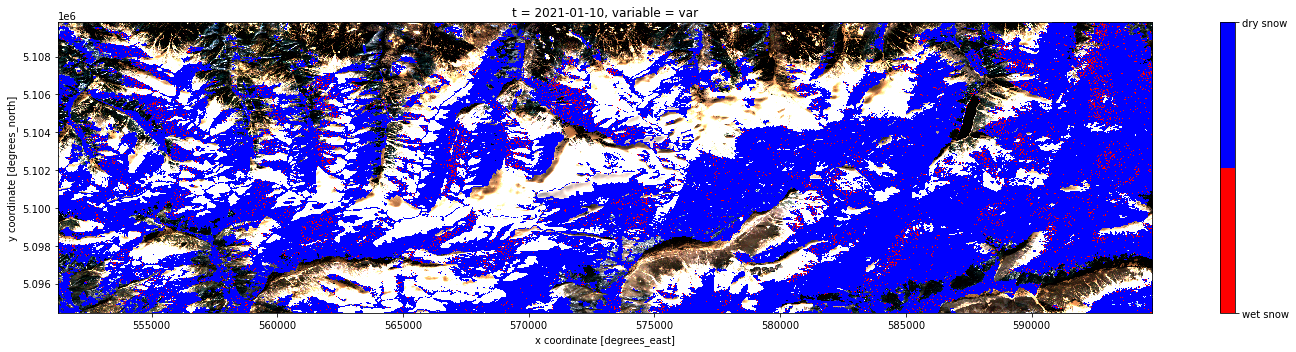

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)
    
fig, ax = plt.subplots(1,figsize=(20,5))
lookup_dict = {(10,10):"r", (20,20):"b"}
S2_BGR.plot.imshow(ax=ax)
im = wetsnow_output[10].plot.imshow(ax=ax,cmap=cmap,add_colorbar=False)
cbar = plt.colorbar(im,ticks=[10,20])
labs = ['wet snow', 'dry snow']
cbar.ax.set_yticklabels(labs)
plt.tight_layout()

Create an animated GIF of the result:

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import gc

if not os.path.exists('GIF'):
    os.mkdir('GIF')
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

for i in range(len(wetsnow_output.t)):
    fig, ax = plt.subplots(1,figsize=(15,4))
    lookup_dict = {(10,10):"r", (20,20):"b"}
    S2_BGR.plot.imshow(ax=ax)
    wetsnow_output[i].plot.imshow(ax=ax,cmap=cmap,add_colorbar=False)
    cbar = plt.colorbar(im,ticks=[10,20])
    labs = ['wet snow', 'dry snow']
    cbar.ax.set_yticklabels(labs)
    plt.tight_layout()
    plt.savefig('GIF/{:02d}.png'.format(i))
    fig.clf()
    plt.close()
    gc.collect()
    
# Build GIF
import imageio
with imageio.get_writer('GIF/wetsnow_animated.gif', mode='I',fps=2) as writer:
    for i in range(len(wetsnow_output.t)):
        image = imageio.imread('GIF/{:02d}.png'.format(i))
        writer.append_data(image)

/tmp/ipykernel_1087/3805157368.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(im,ticks=[10,20])
